# Small Neural Network Regressor (MLP)
This notebook trains a compact feedforward neural network to predict `Passengers` from `final-dataset.csv`.

Design goals:
- Use a small MLP with early stopping for speed and stability.
- Proper preprocessing: one-hot encode categorical features and scale numeric features.
- Consistent metrics: R², RMSE, MAE, MAPE.
- Standard visuals: actual vs predicted, residuals, error distribution.

In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Load and Prepare Data

In [17]:
# Load dataset
df = pd.read_csv('../../data/cleaned/final-dataset.csv')
print('Shape:', df.shape)

target_col = 'Passengers'
categorical_cols = ['Boarding', 'Line', 'Province', 'District']
numeric_cols = [c for c in df.columns if c not in categorical_cols + [target_col, 'Date']]

# Basic overview
print('Target:', target_col)
print('Categorical:', categorical_cols)
print('Numeric count:', len(numeric_cols))
df.head(3)

Shape: (103712, 77)
Target: Passengers
Categorical: ['Boarding', 'Line', 'Province', 'District']
Numeric count: 71


,Station Number,Boarding,Line,Passengers,Year,Month,lat,lng,Province,District,...,Population_Male_0-5,Population_Male_13-18,Population_Male_19-64,Population_Male_6-12,Population_Male_65+,Population_Male_Total,Commercial,Dwelling,Green,Industry
0,150,False,1,1503741,2008,1,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26169.0,42352.0,302800.0,41748.0,21679.0,434748.0,0.0,0.0,0.0,0.0
1,150,False,1,1394346,2008,2,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26175.0,42328.0,303366.0,41444.0,21843.0,435156.0,0.0,0.0,0.0,0.0
2,150,False,1,1518669,2008,3,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26060.0,42549.0,303220.0,41255.0,21981.0,435065.0,0.0,0.0,0.0,0.0


## 2. Train/Test Split & Preprocessing Pipeline

In [23]:
# Split
X = df[categorical_cols + numeric_cols].copy()
y = df[target_col].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes:', X_test.shape, y_test.shape)

# Preprocessor: scale numeric, one-hot encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# Bigger MLP (slightly)
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu', solver='adam',
    alpha=1e-3, batch_size=512,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=300, early_stopping=True,
    random_state=42
)

model = Pipeline(steps=[('preprocess', preprocess), ('mlp', mlp)])
print('Pipeline ready (MLP 128-64-32, max_iter=300, alpha=1e-3).')

Train shapes: (82969, 75) (82969,)
Test shapes: (20743, 75) (20743,)
Pipeline ready (MLP 128-64-32, max_iter=300, alpha=1e-3).


## 3. Train Model

In [ ]:
print('Training... this may take ~1-3 minutes depending on hardware.')
model.fit(X_train, y_train)
print('✓ Training complete.')

Training... this may take ~1-3 minutes depending on hardware.


## 4. Evaluate on Train & Test

In [20]:
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100)

# Train metrics
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = safe_mape(y_train, y_train_pred)

# Test metrics
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = safe_mape(y_test, y_test_pred)

print('TRAIN: R2=', round(train_r2,4), 'RMSE=', int(train_rmse), 'MAE=', int(train_mae), 'MAPE=', train_mape)
print('TEST : R2=', round(test_r2,4), 'RMSE=', int(test_rmse), 'MAE=', int(test_mae), 'MAPE=', test_mape)

# Overfitting check
r2_diff = train_r2 - test_r2
print('R² diff (train - test):', round(r2_diff, 4))

TRAIN: R2= 0.8346 RMSE= 176671 MAE= 108953 MAPE= 301.3634195379468
TEST : R2= 0.8326 RMSE= 177443 MAE= 109802 MAPE= 510.72102212224246
R² diff (train - test): 0.002


## 5. 3-Fold Cross-Validation (optional)

In [21]:
print('Cross-validation (3-fold) — may take a minute...')
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
print('CV R² scores:', [round(float(v),4) for v in cv_scores])
print('CV mean/std:', round(float(cv_scores.mean()),4), round(float(cv_scores.std()),4))

Cross-validation (3-fold) — may take a minute...
CV R² scores: [0.7614, 0.7643, 0.7676]
CV mean/std: 0.7645 0.0025


## 7. Factor Importance (Permutation)

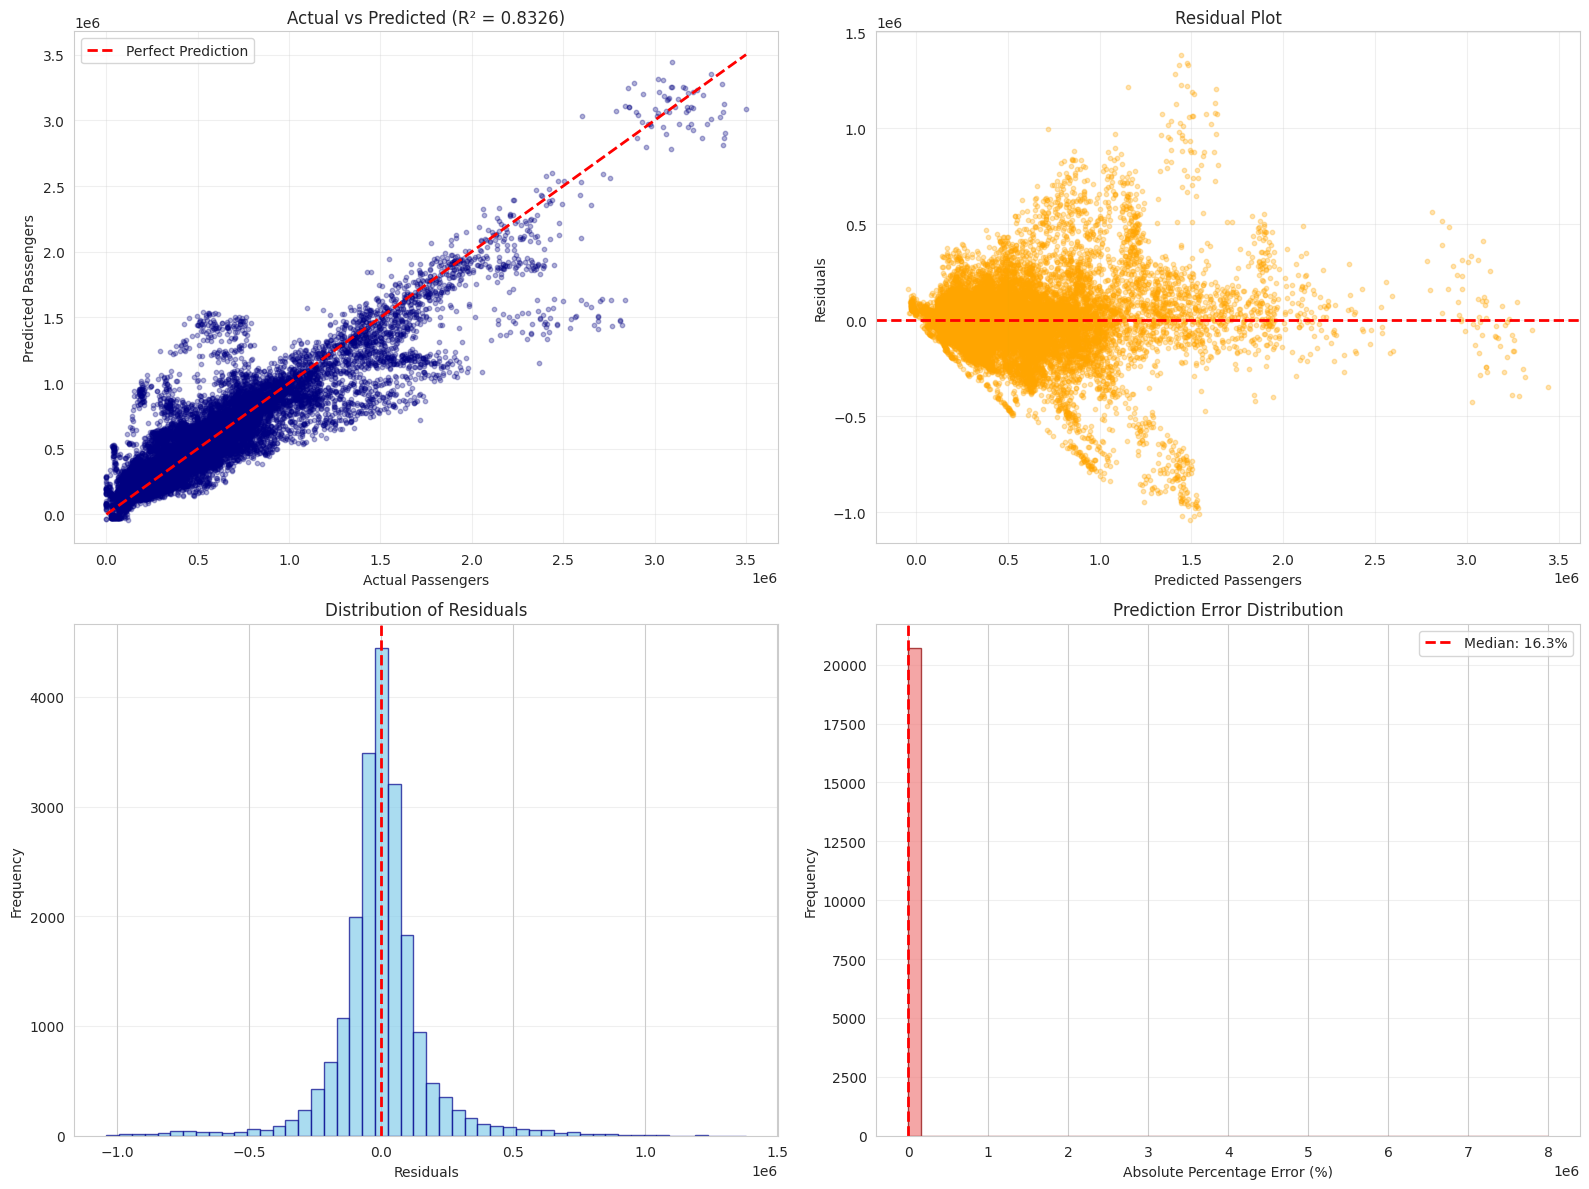

✓ Visualization complete!

Computing permutation importance (this may take a bit)...

Top factors (by permutation importance):
  lng: 18.710034
  District: 14.332980
  lat: 14.132213
  Line: 6.326612
  Province: 2.679880
  Station Number: 2.461159
  Dividend Income Tax: 0.748498
  Population_Female_0-5: 0.497471
  Inheritance Tax: 0.457694
  Employment Income Tax: 0.366501
  Special Tax For Rural Development: 0.352701
  Securities Transaction Tax: 0.344206
  Other Income Tax: 0.264842
  Pension Income Tax: 0.223246
  Transportation¡¤Energy ¡¤ Environment Tax: 0.180092
  Population_0-5: 0.175434
  Liquor Tax: 0.173196
  Stamp Tax: 0.168267
  Business Incometax: 0.144807
  Year: 0.136871


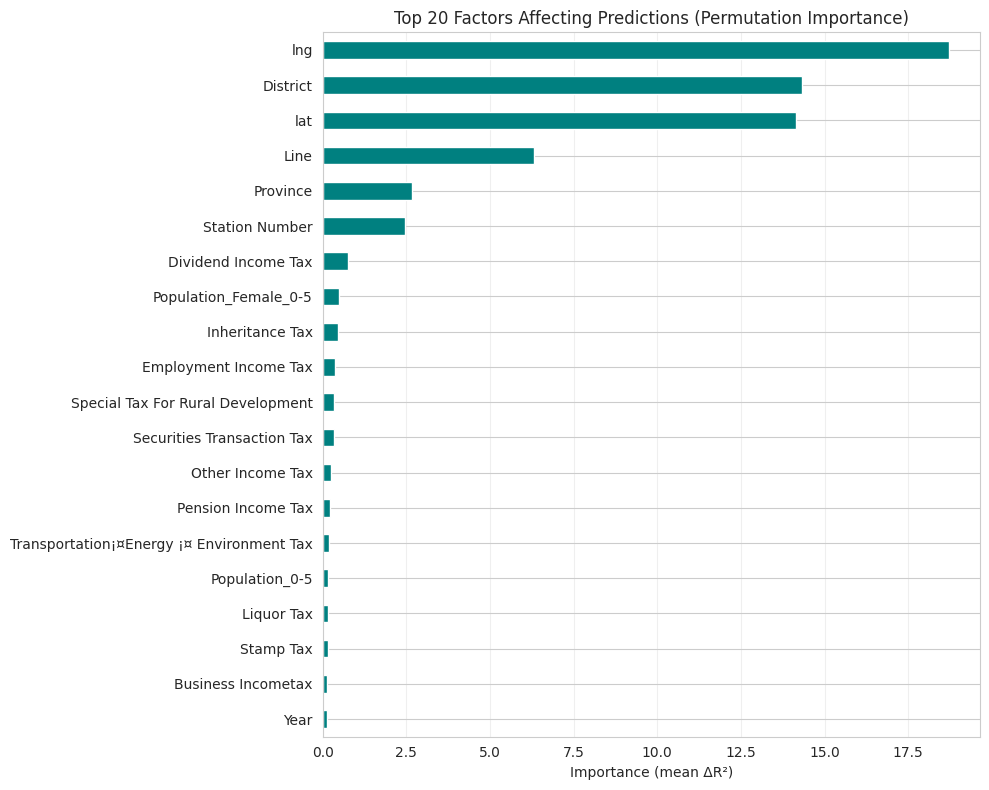

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted
axes[0,0].scatter(y_test, y_test_pred, s=10, alpha=0.3, color='navy')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0,0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0,0].set_xlabel('Actual Passengers')
axes[0,0].set_ylabel('Predicted Passengers')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[0,1].scatter(y_test_pred, residuals, s=10, alpha=0.3, color='orange')
axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0,1].set_title('Residual Plot')
axes[0,1].set_xlabel('Predicted Passengers')
axes[0,1].set_ylabel('Residuals')
axes[0,1].grid(True, alpha=0.3)

# Residual distribution
axes[1,0].hist(residuals, bins=50, color='skyblue', edgecolor='darkblue', alpha=0.7)
axes[1,0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1,0].set_title('Distribution of Residuals')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3, axis='y')

# Error % distribution with zero guard
valid_mask = y_test != 0
error_pct = (np.abs((y_test[valid_mask] - y_test_pred[valid_mask]) / y_test[valid_mask]) * 100) if valid_mask.sum()>0 else np.array([])
if error_pct.size>0:
    axes[1,1].hist(error_pct, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
    axes[1,1].axvline(x=np.median(error_pct), color='r', linestyle='--', lw=2, label=f'Median: {np.median(error_pct):.1f}%')
    axes[1,1].set_title('Prediction Error Distribution')
    axes[1,1].set_xlabel('Absolute Percentage Error (%)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3, axis='y')
else:
    axes[1,1].text(0.5, 0.5, 'No finite percentage errors (all y_test are zero)', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_axis_off()

plt.tight_layout()
plt.show()
print('✓ Visualization complete!')

# Permutation importance (top 20)
from sklearn.inspection import permutation_importance
print('\nComputing permutation importance (this may take a bit)...')
# Sample for speed
sample_n = min(5000, len(X_test))
X_pi = X_test.sample(n=sample_n, random_state=42)
y_pi = y_test.loc[X_pi.index]
result = permutation_importance(model, X_pi, y_pi, n_repeats=5, random_state=42, scoring='r2', n_jobs=-1)
importances = pd.Series(result.importances_mean, index=X_pi.columns).sort_values(ascending=False)

top_k = 20
top_imp = importances.head(top_k)
print('\nTop factors (by permutation importance):')
for name, val in top_imp.items():
    print(f"  {name}: {val:.6f}")

fig2, ax = plt.subplots(figsize=(10, 8))
top_imp[::-1].plot(kind='barh', ax=ax, color='teal')
ax.set_title('Top 20 Factors Affecting Predictions (Permutation Importance)')
ax.set_xlabel('Importance (mean ΔR²)')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()